In [1]:
import math
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
def generate_sample_f_star(N, t="uniform", densities=None, selected_densities=None, s=5, cvx_rand=False, dist_rect=None, N_pdf=1000):
    # Generate a sample of n points in [0,1]
    # t can be uniform, convex, rect, in the case of convex, a convex combination of elements of gaussian 
    # densities will be taken with a sparsity s
    #we return also return the distribution on [0,1], 1000 points
    if t=="uniform":
        X_ = np.random.uniform(low=0, high=1, size=N)
        return X_, 1./N_pdf*np.ones(N_pdf)
    if t=="convex":
        if densities == None:
            raise ValueError("Densities were not given")
        def generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters, weights):
            print "selected densities: ", sorted(zip(selected_densities,weights))
            X = np.array([])
            t=0
            #We generate the sample according to the selected densities and the weights
            for i in range(s):
                X=np.hstack((X, densities[selected_densities[i]].rvs(sample_repartition_among_clusters[i])))
            np.random.shuffle(X)
            return X, np.apply_along_axis(lambda x: weights.dot(np.array([densities[i].pdf(x) for i in selected_densities])), 0, np.linspace(0,1,N_pdf)), weights, selected_densities
        # We select randomly s elements in densities, then we have two possibilities depending on cvx_rand:
        # false: equal weight for each densities, w=1/s
        # true: random weights
        if selected_densities == None:
            selected_densities = np.random.choice(len(densities), s, replace=False)
        s = len(selected_densities)
        if cvx_rand:
            #We generate the weights
            weights = np.random.randint(N*100, size=(1, s))[0]
            weights = 1.*weights/weights.sum()
            sample_repartition_among_clusters = np.random.multinomial(N, weights, size=1)[0]
            return generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters, weights)
        else:
            a = round(N/s)*np.ones(s)
            #We adjust the size to the last element
            a[-1]= a[-1]-(a.sum()-N)
            sample_repartition_among_clusters = a.astype(int)
            return generate_points(N, s, densities, selected_densities, sample_repartition_among_clusters, a/a.sum())
    if t=="rect":
        def prob_estim(x, dist_rect):
            for intval in sorted(dist_rect.keys()):
                if x <= intval[1]:
                    return dist_rect[intval]
        X_ = np.linspace(0,1,10*N)
        proba = np.array([prob_estim(x, dist_rect) for x in X_])
        proba = proba/proba.sum()
        return np.random.choice(X_, size=N, p=proba), np.array([prob_estim(x,dist_rect) for x in np.linspace(0, 1, N_pdf)])
                
            

        
        
        
        

selected densities:  [(1, 0.028566371877195022), (11, 0.11365710398380593), (16, 0.41717964459340623), (17, 0.19005348244260453), (31, 0.25054339710298829)]


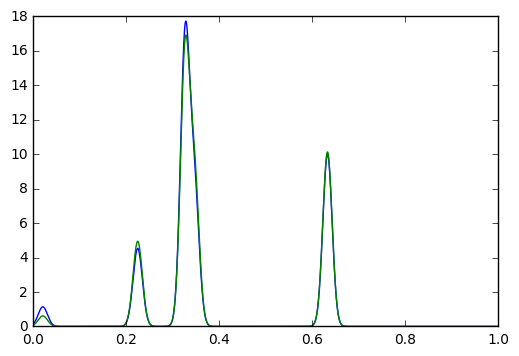

In [5]:
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from algorithm import WeightEstimator

nodes = np.linspace(0, 1, 50)
var = 10**(-4)
densities = [multivariate_normal(m, var) for m in nodes]
dist_rect = {
    (0,1./5) : 10./7,
    (1./5,2./5) : 5./7,
    (2./5,3./5) : 10./7,
    (3./5,4./5) : 0,
    (4./5,1) : 10./7
}
n_pdf = 100000
#X, f_star = generate_sample_f_star(10000, t="rect", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect, N_pdf=n_pdf)
#X, f_star = generate_sample_f_star(1000, t="uniform", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)#
X, f_star,  weights_star, selected_densities_star = generate_sample_f_star(1000, t="convex", densities=densities, cvx_rand=True, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)
#X, f_star, weights_star, selected_densities_star = generate_sample_f_star(100, t="convex", densities=densities, cvx_rand=False, s=5, dist_rect=dist_rect,  N_pdf=n_pdf)
#plt.hist(X, bins=1000)  # plt.hist passes it's arguments to np.histogram

#estimation
cl = WeightEstimator(densities_dict=densities, select_threshold=10e-3)
cl.fit(X)
estim_weighted_densities=cl.select_densities()
selected_densities_estim, weights_estim = np.array(zip(*estim_weighted_densities))
f_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))

plt.plot(np.linspace(0,1,n_pdf),f_star)
plt.plot(np.linspace(0,1,n_pdf),f_estim)
plt.show()


# Evaluation

In [6]:
#Kullback Leibler:

from scipy.stats import entropy
#import scipy.integrate as integrate
#integrate.quad(lambda x: x**2, 0, 1)

print "KL-div:", entropy(f_star, f_estim)
print "L2 norm", 1./n_pdf*np.linalg.norm(f_star-f_estim,axis=0)**2
print weights_estim, weights_star

KL-div: 0.00564475075412
L2 norm 0.0239401503224
[ 0.01538535  0.12398659  0.3938183   0.20718178  0.25400003] [ 0.02856637  0.1136571   0.19005348  0.41717964  0.2505434 ]


# SPADES Implementation

In [7]:
#from SPADES AND MIXTURE MODELS
#By Florentina Bunea, Alexandre B. Tsybakov,
#Marten H. Wegkamp and Adrian Barbu
#another implementation

from cvxpy import *

In [8]:
def F(x):
    return np.array([d.pdf(x) for d in densities]).T

In [9]:
#objective = Minimize(-2./X.shape[0]*sum_entries(F_X*lambda_) + norm2_f_sq + 2*norm1(w*lambda_) )
#prob = Problem(objective)
#prob.solve()

## selection des poids pour spades

In [10]:
#n=10000
#(1./n*np.array([x**2 for x in np.linspace(0,1,n)])).sum()
F_X=F(X)

In [11]:
import scipy.integrate as integrate
from numba import jit
K = len(densities)

@jit()
def couple_dens(x,i,j):
    return densities[i].pdf(x)*densities[j].pdf(x)

#this code generate a matrix where the comp.(i,j) is int(densities[i]*densities[j])
def F_int_prod_matrix():
    F_int_prod_matrix = np.zeros([K,K])
    for i in range(K):
        for j in range(i,K):
            F_int_prod_matrix[i,j]=integrate.quad(couple_dens,-np.inf,np.inf,args=(i,j))[0]
    return F_int_prod_matrix + np.triu(F_int_prod_matrix,1).T

#differential of -2/n * sum_{i=1}^K(f_lambd(X_i))+ ||f_lambd||^2
# which is -2/n * sum_{i=1}^K f_l(X_i) + 2*sum_{i=1}^K lambd_j*int(f_j(x)*f_l(x))
#@jit()
def f_diff(l, lambd, F_X, f_int_prod_matrix):
    #import pdb; pdb.set_trace()
    return -2./F_X.shape[0]*F_X[:,l].sum() + 2*f_int_prod_matrix[:,l].dot(lambd)

#Evaluation of the norm2 of f_lambd
def norm_2_integrand(x,lambd_):
    return (np.array([d.pdf(x) for d in densities]).dot(lambd_))**2

def f_norm2(lambd_):
    return integrate.quad(norm_2_integrand,-np.inf,np.inf,args=lambd_)[0]

#for line search
#@jit()
def f(lambd_, w, F_X):
    return -2./F_X.shape[0]*F_X.dot(lambd_).sum()+f_norm2(lambd_) + w*np.linalg.norm(lambd_,1)

#grad for line search
def f_grad(lambd_, w):
    return np.array([f_diff(l,lambd_) for l in range(K)]) + w*np.sign(lambd_)



In [13]:
f_int_prod_matrix = F_int_prod_matrix()

In [14]:
def min_direct(lambd, l, F_X, w):
    lambda_ = Variable(K)
    #pour le calcul de l'integrale
    X_int = np.linspace(0,1,10000)
    F_int = F(X_int)*lambda_
    norm2_f_sq = sum_entries(F_int**2)
    #prepare constraints
    lst_cst = range(K,l)
    constraints = [lambda_[i]==lambd[i] for i in lst_cst]
    #problem
    objective = Minimize(-2./F_X.shape[0]*sum_entries(F_X*lambda_) + norm2_f_sq + 2*norm1(w*lambda_) )
    prob = Problem(objective,constraints)
    prob.solve()
    return np.array(lambda_.value).reshape(1,K)[0]

In [15]:
from scipy.optimize import minimize
#@jit()
def f_one_direct(y, l, lambd_, w, F_X, f_int_prod_matrix):
    lambd_[l]=y
    return f(lambd_, w, F_X)

def f_grad_one_direct(y, l, lambd_, w, F_X, F_int_prod_matrix):
    #import pdb; pdb.set_trace()
    return -2./F_X.shape[0]*F_X[:,l].sum() + 2*f_int_prod_matrix[:,l].dot(lambd_) + w*np.sign(y)


#@jit()
def min_direct_2(lambd, l, w, F_X, f_int_prod_matrix):
    res = minimize(f_one_direct, 
                   lambd[l], 
                   args=(l, lambd, w, F_X, f_int_prod_matrix), 
                   method="BFGS",
                   jac=f_grad_one_direct, 
                   options={"maxiter":1,
                            "disp": True
                           
                           }
                  )["x"][0]
    lambd_res = np.copy(lambd)
    lambd_res[l]=res
    return lambd_res
        
    

In [16]:
#@jit()
def spades(w, F_X, f_int_prod_matrix):
    eps_tresh = 1e-5
    lambd = 1./K*np.ones(K)
    lambd_old = np.zeros(K)
    #import pdb; pdb.set_trace()
    it = 0
    while np.linalg.norm(lambd-lambd_old,1) > eps_tresh:
        #print "iteration: ", it, "norm: ", np.linalg.norm(lambd-lambd_old,1)
        for j in range(K):
            lambd_old = np.copy(lambd)
            lambd_j_0 = np.copy(lambd)
            lambd_j_0[j]=0
            if np.abs(f_diff(j, lambd_j_0, F_X, f_int_prod_matrix)) < w:
                lambd = lambd_j_0
            else:
                #lambd = min_direct_2(lambd, j, w, F_X, F_int_prod_matrix)
                lambd = min_direct(lambd, j, F_X, w)
        it+=1
    return lambd

In [17]:
lambd = spades(0.1, F_X, f_int_prod_matrix)
lambd[0]

SolverError: Solver 'ECOS' failed. Try another solver.

In [ ]:
lambd.reshape(1,K)[0]

In [ ]:
weight_spades_2 = np.array([lambd[i] if type(lambd[i]) == int else np.array(lambd[i])[0][0] for i in range(K)])

In [18]:
f_estim_spades_2 = np.apply_along_axis(lambda x: weight_spades_2.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))

#plt.plot(np.linspace(0,1,n_pdf),f_star)
plt.plot(np.linspace(0,1,n_pdf),f_estim_spades_2)
plt.show()

NameError: global name 'weight_spades_2' is not defined

In [40]:
def spades_full(w, F_X, f_int_prod_matrix):
    lambda_ = Variable(K)
    #import pdb; pdb.set_trace()
    X_int = np.linspace(0,1,10000)
    F_int = F(X_int)*lambda_
    norm2_f_sq = sum_entries(F_int**2)
    objective = Minimize(-2/X.shape[0]*sum_entries(F_X*lambda_) + norm2_f_sq + 2*norm1(w*lambda_) )
    prob = Problem(objective)
    prob.solve()
    return np.array(lambda_.value).reshape(1,K)[0]


In [20]:
for i in range(10):
    w=10**(2-i)
    weights_spades = np.array(spades_full(w)).reshape(K)
    f_estim_spades = np.apply_along_axis(lambda x: weights_spades.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))
    
    plt.plot(np.linspace(0,1,n_pdf),f_star)
    plt.plot(np.linspace(0,1,n_pdf),f_estim_spades)
    plt.show()

TypeError: spades_full() takes exactly 3 arguments (1 given)

In [21]:
1e-3

0.001

In [22]:
weights_spades.dot(np.array([d.pdf(0) for d in densities]))

NameError: name 'weights_spades' is not defined

In [23]:
def non_zero_elemts(w, F_X, f_int_prod_matrix):
    lambd = spades_full(w, F_X, f_int_prod_matrix)
    return len(lambd[lambd>1e-10]), lambd

In [62]:
#GBM Methods
from queue import Queue
alpha = 1e-2
def gbm(X, F_X, f_int_prod_matrix, alpha=1e-2):
    w_vect = -np.ones(K)
    w_vect[0] = 
    w_vect[-1] = 0
    #import pdb; pdb.set_trace()
    q = Queue()
    q.put((w_vect[0],w_vect[-1]))
    while not q.empty():
        a,b = q.get()
        w = 1.0*(a+b)/2
        k = non_zero_elemts(w, F_X, f_int_prod_matrix)[0]-1
        if w_vect[k]==(-1):
            w_vect[k]=w
        t = non_zero_elemts(a, F_X, f_int_prod_matrix)[0]
        if np.abs(t-k) > 1 and np.abs(a-w) > alpha:
            q.put((a,w))
        t = non_zero_elemts(b, F_X, f_int_prod_matrix)[0]
        if np.abs(t-k) > 1 and np.abs(b-w) > alpha:
            q.put((w,b))
    return w_vect

SyntaxError: invalid syntax (<ipython-input-62-ef6330b6f804>, line 6)

In [34]:
non_zero_elemts(1, F_X, f_int_prod_matrix)

(17, array([[  1.69088992e-04],
        [  6.49045989e-04],
        [  3.44234394e-04],
        [ -8.31277689e-05],
        [  2.15219117e-05],
        [ -2.77321009e-06],
        [ -9.73680875e-11],
        [ -1.32981418e-06],
        [  1.67120738e-05],
        [ -6.47438523e-05],
        [  2.31761089e-04],
        [  5.81553745e-03],
        [  3.40934277e-04],
        [ -1.46514352e-04],
        [  1.22397434e-04],
        [ -4.00331154e-04],
        [  1.98776362e-02],
        [  1.08158675e-02],
        [ -4.02786663e-04],
        [  8.44357674e-05],
        [ -2.17463031e-05],
        [  2.85566292e-06],
        [  4.17659014e-11],
        [  8.43188261e-12],
        [ -7.33338511e-13],
        [  1.29854996e-13],
        [  9.33820876e-13],
        [ -3.81111901e-12],
        [ -1.86034903e-11],
        [ -4.87819674e-11],
        [ -1.40112250e-04],
        [  1.22055278e-02],
        [  8.70585390e-04],
        [ -3.05489665e-04],
        [  1.00437978e-04],
        [ -2.907

In [35]:
gbm(X, F_X,f_int_prod_matrix)

put b, w  0.0 50.0
put b, w  0.0 25.0
put a,w 25.0 12.5
put b, w  0.0 12.5
put b, w  12.5 18.75
put b, w  0.0 6.25
put b, w  12.5 15.625
put b, w  0.0 3.125
put b, w  0.0 1.5625
put b, w  0.0 0.78125
put a,w 0.78125 0.390625
put b, w  0.0 0.390625
put b, w  0.390625 0.5859375
put b, w  0.0 0.1953125
put b, w  0.390625 0.48828125
put b, w  0.0 0.09765625
put b, w  0.390625 0.439453125
put a,w 0.09765625 0.048828125
put b, w  0.0 0.048828125
put b, w  0.390625 0.4150390625
put a,w 0.09765625 0.0732421875
put b, w  0.0 0.0244140625
put b, w  0.390625 0.40283203125
put b, w  0.0732421875 0.08544921875


array([  1.00000000e+02,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,   5.00000000e+01,
         2.50000000e+01,   1.56250000e+01,  -1.00000000e+00,
         1.25000000e+01,  -1.00000000e+00,   3.12500000e+00,
        -1.00000000e+00,   1.56250000e+00,  -1.00000000e+00,
         5.85937500e-01,   4.88281250e-01,  -1.00000000e+00,
         4.39453125e-01,   3.90625000e-01,   8.54492188e-02,
         7.93457031e-02,   4.88281250e-02,   1.22070312e-02,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,

In [45]:
w_test = np.array([  1.00000000e+02,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,   5.00000000e+01,
         2.50000000e+01,   1.56250000e+01,  -1.00000000e+00,
         1.25000000e+01,  -1.00000000e+00,   3.12500000e+00,
        -1.00000000e+00,   1.56250000e+00,  -1.00000000e+00,
         5.85937500e-01,   4.88281250e-01,  -1.00000000e+00,
         4.39453125e-01,   3.90625000e-01,   8.54492188e-02,
         7.93457031e-02,   4.88281250e-02,   1.22070312e-02,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000000e+00,   0.00000000e+00])
print w_test[14]
res_test = spades_full(w_test[14],  F_X, f_int_prod_matrix)
len(res_test[res_test>1e-10])

3.125


15

In [65]:
def D_comp(X, j, p):
    mask = np.ones(X.shape, dtype=bool)
    mask[X.shape[0]/p*j:X.shape[0]/p*(j+1)] = False
    return X[mask]

def weight_select_proc(X):
    f_int_prod_matrix = F_int_prod_matrix()
    p=10
    #Dj
    part_X = []
    for i in range(p):
        part_X.append(X[X.shape[0]/p*i:X.shape[0]/p*(i+1)])
    #we create D-j : D\Dj
    part_X_comp = []
    for l in range(K):
        part_X_comp.append(D_comp(X,l,p))
    L = np.zeros([K,p])
    #import pdb; pdb.set_trace()
    w_list=[]
    for k in range(K):
        for j in range(p):
            F_X_j = F(part_X_comp[j])
            w_k_j = gbm(part_X_comp[j], F_X_j, f_int_prod_matrix)
            w_list.append((k,j,w_k_j))
            print w_k_j
    return w_list

In [ ]:
a = weight_select_proc(X)

In [ ]:
mask = np.ones(X.shape, dtype=bool)
mask[X.shape[0]/10*3:X.shape[0]/10*(3+1)] = False
X[mask]

In [ ]:
np.array([[1,2],[4,5]])[0,0]

In [ ]:
F_X.shape

In [ ]:
pwet = range(K)
l =5
range(K,5)

In [ ]:
pwet[5:]

In [56]:
@jit
def test():
    return np.zeros([10,10])

In [57]:
test()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])